In [10]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
import faiss
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import wraps


In [12]:

class TimingProfiler:
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Reset all timing data and context stack"""
        self.timing_data = defaultdict(list)
        self._context_stack = []
    
    def start_operation(self, name):
        """Start timing an operation"""
        self._context_stack.append((name, time.perf_counter()))
    
    def end_operation(self):
        """End timing the current operation"""
        if self._context_stack:
            name, start_time = self._context_stack.pop()
            duration = time.perf_counter() - start_time
            self.timing_data[name].append(duration)
            return duration
        return 0
    
    def profile(self, func):
        """Decorator for profiling entire functions"""
        @wraps(func)
        def wrapper(*args, **kwargs):
            self.start_operation(func.__name__)
            result = func(*args, **kwargs)
            self.end_operation()
            return result
        return wrapper
    
    def plot_timing_breakdown(self):
        """Create a detailed timing breakdown visualization"""
        if not self.timing_data:
            print("No timing data available. Run profiled functions first.")
            return None
            
        # Process timing data
        df = pd.DataFrame([
            {'Operation': key, 'Time': value}
            for key, values in self.timing_data.items()
            for value in values
        ])
        
        # Calculate statistics
        stats = df.groupby('Operation').agg({
            'Time': ['mean', 'sum', 'count']
        }).round(6)
        stats.columns = ['Mean (s)', 'Total (s)', 'Calls']
        stats = stats.sort_values(('Total (s)'), ascending=False)
        
        # Create hierarchical structure
        operations = {}
        for op in df['Operation'].unique():
            if '.' in op:
                parent, child = op.split('.', 1)
                if parent not in operations:
                    operations[parent] = []
                operations[parent].append(op)
        
        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])
        
        # Plot 1: Stacked bar chart
        parent_times = defaultdict(float)
        bottom = defaultdict(float)
        bar_width = 0.35
        colors = plt.cm.Set3(np.linspace(0, 1, len(df['Operation'].unique())))
        color_map = dict(zip(df['Operation'].unique(), colors))
        
        # Plot parent totals
        x_pos = 0
        x_ticks = []
        x_labels = []
        
        for parent in operations:
            parent_total = sum(stats.loc[child, ('Total (s)')] for child in operations[parent])
            ax1.bar(x_pos, parent_total, bar_width, 
                   color='lightgray', alpha=0.3,
                   label=f'Total {parent}')
            
            # Plot children
            for child in operations[parent]:
                child_time = stats.loc[child, ('Total (s)')]
                ax1.bar(x_pos + bar_width, child_time, bar_width,
                       bottom=bottom[parent],
                       color=color_map[child],
                       label=f"{child}\n({child_time:.3f}s)")
                bottom[parent] += child_time
            
            x_ticks.append(x_pos + bar_width/2)
            x_labels.append(f"{parent}\n({parent_total:.3f}s)")
            x_pos += 1.5
        
        ax1.set_title('Execution Time Breakdown')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels(x_labels)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: Statistics table
        ax2.axis('tight')
        ax2.axis('off')
        table_data = [[op] + list(row) for op, row in stats.iterrows()]
        table_cols = ['Operation'] + list(stats.columns)
        table = ax2.table(cellText=table_data,
                         colLabels=table_cols,
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.4] + [0.2] * len(stats.columns))
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        plt.tight_layout()
        return fig

# Create a global profiler instance
profiler = TimingProfiler()

@profiler.profile
def get_points_in_invlists(index, invlists, DEBUG=False):
    tmp_pids, tmp_codes = [], []
    
    profiler.start_operation('get_points_in_invlists.loop')
    for invlist_id in invlists:
        point_ids, codes = get_invlist(index.invlists, int(invlist_id))
        tmp_pids.append(point_ids)
        tmp_codes.append(codes)
    profiler.end_operation()
    
    profiler.start_operation('get_points_in_invlists.concatenate')
    pids_visited = np.concatenate(tmp_pids, axis=0)
    p_visited = np.concatenate(tmp_codes, axis=0).view("float32")
    profiler.end_operation()
    
    return pids_visited, p_visited

@profiler.profile
def get_invlist(invlists, l):
    profiler.start_operation('get_invlist.downcast')
    invlists = faiss.downcast_InvertedLists(invlists)
    profiler.end_operation()
    
    profiler.start_operation('get_invlist.list_size')
    ls = invlists.list_size(l)
    profiler.end_operation()
    
    profiler.start_operation('get_invlist.setup')
    list_ids = np.zeros(ls, dtype='int64')
    ids = codes = None
    profiler.end_operation()
    
    try:
        profiler.start_operation('get_invlist.memcpy_ids')
        ids = invlists.get_ids(l)
        if ls > 0:
            faiss.memcpy(faiss.swig_ptr(list_ids), ids, list_ids.nbytes)
        profiler.end_operation()
        
        profiler.start_operation('get_invlist.memcpy_codes')
        codes = invlists.get_codes(l)
        if invlists.code_size != faiss.InvertedLists.INVALID_CODE_SIZE:
            list_codes = np.zeros((ls, invlists.code_size), dtype='uint8')
        else:
            npb = invlists.n_per_block
            bs = invlists.block_size
            ls_round = (ls + npb - 1) // npb
            list_codes = np.zeros((ls_round, bs // npb, npb), dtype='uint8')
        if ls > 0:
            faiss.memcpy(faiss.swig_ptr(list_codes), codes, list_codes.nbytes)
        profiler.end_operation()
        
    finally:
        profiler.start_operation('get_invlist.release_resources')
        if ids is not None:
            invlists.release_ids(l, ids)
        if codes is not None:
            invlists.release_codes(l, codes)
        profiler.end_operation()
    
    return list_ids, list_codes

def test_performance(c_visited_ids, outer_index, DEBUG=False):
    """Run performance test with fresh timing data"""
    profiler.reset()  # Reset timing data before each test
    pids_visited, p_visited = get_points_in_invlists(index=outer_index, invlists=c_visited_ids, DEBUG=DEBUG)
    return pids_visited, p_visited


The following functions are overriding some of the imported ones in faiss, don't load faiss after

In [13]:
# def test_performance(c_visited_ids, outer_index, DEBUG=False):
#     """ Helper function to test performance with varying numbers of c_visited_ids. """
#     start_time = time.perf_counter()
#     pids_visited, p_visited = get_points_in_invlists(index=outer_index, invlists=c_visited_ids, DEBUG=DEBUG)
#     end_time = time.perf_counter()
#     print(f"Total get_points_in_invlists took {end_time - start_time:.6f} seconds")
    # return pids_visited, p_visited

def train_ivfflat(
    data,
    nlist=10,
    km_n_iter=10,
    km_max_pts=256,
    seed=1,
    nredo=1,
    verbose=True,
    store_dir=None,
    metric='euclidean',
):
    print(f"Kmeans... {nlist=} {km_n_iter=} {km_max_pts=} {seed=} {nredo=}")
    nb, d = data.shape

    quantizer = faiss.IndexFlatL2(d)
    if metric == "euclidean":
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    elif metric == "angular":
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
    
    index.cp.seed = seed
    index.cp.niter = km_n_iter
    index.cp.max_points_per_centroid = km_max_pts
    index.cp.nredo = nredo
    index.verbose = verbose

    strain = time.perf_counter()
    index.train(data)
    etrain = time.perf_counter()

    sadd = time.perf_counter()
    index.add(data)
    eadd = time.perf_counter()

    if store_dir is not None:
        filename = (
            store_dir
            + f"/index-n_iter_{km_n_iter}-nlist_{nlist}-max_pts_{km_max_pts}-seed_{seed}.index"
        )
        if args.store:
            print("storing index", filename)
            faiss.write_index(index, filename)
    
    print(f"\t---> Index Train Time = {(etrain - strain)*1000} ms | Add Time = {(eadd - sadd)*1000} ms <---")
    return index, etrain - strain, eadd - sadd


def read_ivecs(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()

def read_fvecs(fname):
    return read_ivecs(fname).view('float32')


def load_sift1M(PATH):
    """
    Load SIFT1M from fvecs data. 
    
    If in system group servers:
        DATA_PATH = f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean"
    If local macbook:
        DATA_PATH = "/Users/mageirakos/Documents/projects/crack-vdb/data/" # local
    """
    print("Loading sift1M...", end='', file=sys.stderr)
    xt = read_fvecs(f"{PATH}/sift_learn.fvecs")
    xb = read_fvecs(f"{PATH}/sift_base.fvecs")
    xq = read_fvecs(f"{PATH}/sift_query.fvecs")
    gt = read_ivecs(f"{PATH}/sift_groundtruth.ivecs")
    print("done", file=sys.stderr)
    metric = 'euclidean'
    print("dataset shape:")
    print(f"{xb.shape=}")
    print(f"{gt.shape=}")
    print(f"{xq.shape=}")
    xb, xq, xt, gt = np.array(xb), np.array(xq), np.array(xt), np.array(gt)
    return xb, xq, xt, gt, metric


# def save_timing_data(filepath):
#     df = pd.DataFrame([
#         {'Operation': key, 'Time (s)': value}
#         for key, values in timing_data.items()
#         for value in values
#     ])
#     df.to_csv(filepath, index=False)


In [14]:
DATASET = "SIFT1M"
#NOTE: limited to first 10ak queries from dataset
xb, xq, xt, gt, metric = load_sift1M("/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")
# xt = None
index, train_time, add_time = train_ivfflat(
    xb,
    nlist=1000,
    km_n_iter=10,
    km_max_pts=256,
    seed=1,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric='euclidean',
)

Loading sift1M...done


dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)
Kmeans... nlist=1000 km_n_iter=10 km_max_pts=256 seed=1 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 6700.909318002232 ms | Add Time = 2888.617951000924 ms <---IndexIVFFlat::add_core: added 1000000 / 1000000 vectors



In [15]:
faiss.omp_set_num_threads(1)

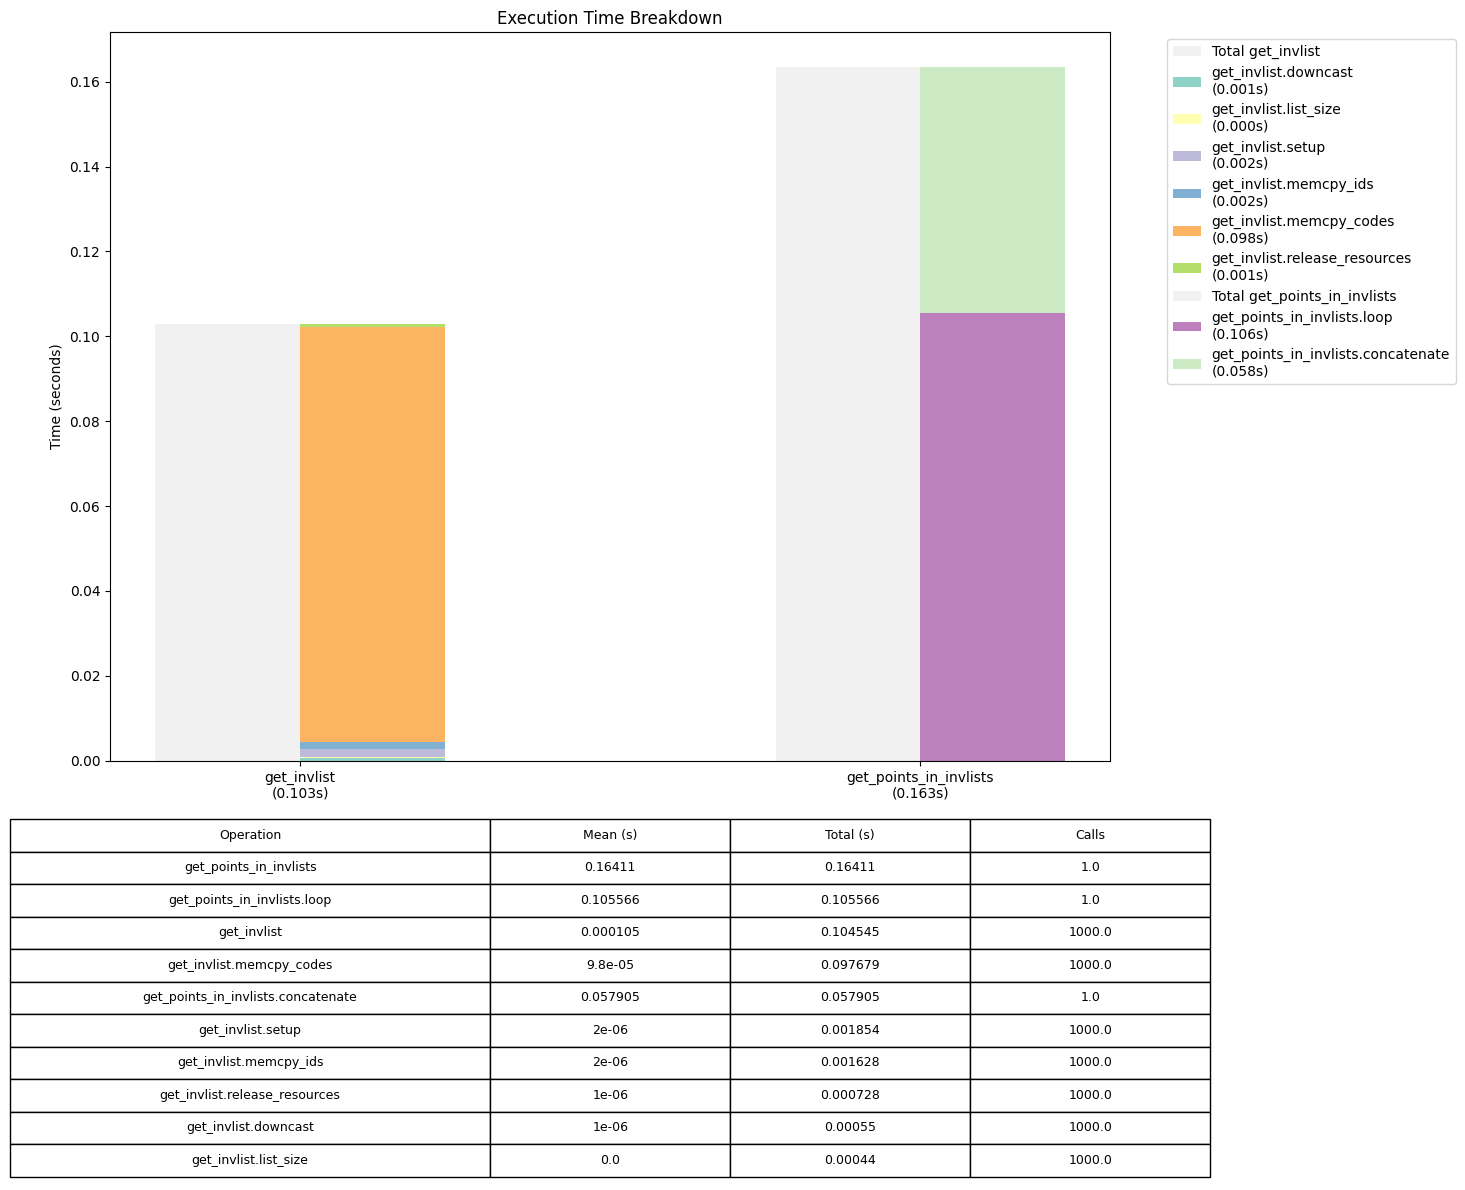

In [20]:
# For each test run, clear any existing plots first
plt.close('all')  

# Run the test
c_visited_ids = list(range(1000))
pids_visited, p_visited = test_performance(c_visited_ids, index, DEBUG=True)

# Create and show the plot
fig = profiler.plot_timing_breakdown()  # Get the figure object
if fig:  # Only show if we got a valid figure
    plt.show()
    plt.close(fig)  # Clean up after showing

# Save timing data if needed
df = pd.DataFrame([
    {'Operation': key, 'Time (s)': value}
    for key, values in profiler.timing_data.items()
    for value in values
])
df.to_csv('timing_data.csv', index=False)

# Test get_pids only and slice poitns from np array ( just for prototype code )

note get_inv_list is modified here:

In [21]:
import faiss
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import wraps

class TimingProfiler:
    def __init__(self):
        self.reset()
    
    def reset(self):
        """Reset all timing data and context stack"""
        self.timing_data = defaultdict(list)
        self._context_stack = []
    
    def start_operation(self, name):
        """Start timing an operation"""
        self._context_stack.append((name, time.perf_counter()))
    
    def end_operation(self):
        """End timing the current operation"""
        if self._context_stack:
            name, start_time = self._context_stack.pop()
            duration = time.perf_counter() - start_time
            self.timing_data[name].append(duration)
            return duration
        return 0
    
    def profile(self, func):
        """Decorator for profiling entire functions"""
        @wraps(func)
        def wrapper(*args, **kwargs):
            self.start_operation(func.__name__)
            result = func(*args, **kwargs)
            self.end_operation()
            return result
        return wrapper
    
    def plot_timing_breakdown(self):
        """Create a detailed timing breakdown visualization"""
        if not self.timing_data:
            print("No timing data available. Run profiled functions first.")
            return None
            
        # Process timing data
        df = pd.DataFrame([
            {'Operation': key, 'Time': value}
            for key, values in self.timing_data.items()
            for value in values
        ])
        
        # Calculate statistics
        stats = df.groupby('Operation').agg({
            'Time': ['mean', 'sum', 'count']
        }).round(6)
        stats.columns = ['Mean (s)', 'Total (s)', 'Calls']
        stats = stats.sort_values(('Total (s)'), ascending=False)
        
        # Create hierarchical structure
        operations = {}
        for op in df['Operation'].unique():
            if '.' in op:
                parent, child = op.split('.', 1)
                if parent not in operations:
                    operations[parent] = []
                operations[parent].append(op)
        
        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])
        
        # Plot 1: Stacked bar chart
        parent_times = defaultdict(float)
        bottom = defaultdict(float)
        bar_width = 0.35
        colors = plt.cm.Set3(np.linspace(0, 1, len(df['Operation'].unique())))
        color_map = dict(zip(df['Operation'].unique(), colors))
        
        # Plot parent totals
        x_pos = 0
        x_ticks = []
        x_labels = []
        
        for parent in operations:
            parent_total = sum(stats.loc[child, ('Total (s)')] for child in operations[parent])
            ax1.bar(x_pos, parent_total, bar_width, 
                   color='lightgray', alpha=0.3,
                   label=f'Total {parent}')
            
            # Plot children
            for child in operations[parent]:
                child_time = stats.loc[child, ('Total (s)')]
                ax1.bar(x_pos + bar_width, child_time, bar_width,
                       bottom=bottom[parent],
                       color=color_map[child],
                       label=f"{child}\n({child_time:.3f}s)")
                bottom[parent] += child_time
            
            x_ticks.append(x_pos + bar_width/2)
            x_labels.append(f"{parent}\n({parent_total:.3f}s)")
            x_pos += 1.5
        
        ax1.set_title('Execution Time Breakdown')
        ax1.set_ylabel('Time (seconds)')
        ax1.set_xticks(x_ticks)
        ax1.set_xticklabels(x_labels)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot 2: Statistics table
        ax2.axis('tight')
        ax2.axis('off')
        table_data = [[op] + list(row) for op, row in stats.iterrows()]
        table_cols = ['Operation'] + list(stats.columns)
        table = ax2.table(cellText=table_data,
                         colLabels=table_cols,
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.4] + [0.2] * len(stats.columns))
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        plt.tight_layout()
        return fig

# Create a global profiler instance
profiler = TimingProfiler()

@profiler.profile
def get_points_in_invlists(index, invlists, xb, DEBUG=False):
    # CHEF NOTE: change here to have xb
    tmp_pids, tmp_codes = [], []
    
    profiler.start_operation('get_points_in_invlists.loop')
    for invlist_id in invlists:
        # CHEF NOTE: codes is not needed
        point_ids, _ = get_invlist(index.invlists, int(invlist_id))
        tmp_pids.append(point_ids)
        # tmp_codes.append(codes)
    profiler.end_operation()
    
    profiler.start_operation('get_points_in_invlists.concatenate')
    pids_visited = np.concatenate(tmp_pids, axis=0)
    # get from xb
    # CHEF NOTE: change here to have xb
    p_visited = xb[pids_visited].view("float32")
    # p_visited = np.concatenate(tmp_codes, axis=0).view("float32")
    profiler.end_operation()
    
    return pids_visited, p_visited

@profiler.profile
def get_invlist(invlists, l):
    profiler.start_operation('get_invlist.downcast')
    invlists = faiss.downcast_InvertedLists(invlists)
    profiler.end_operation()
    
    profiler.start_operation('get_invlist.list_size')
    ls = invlists.list_size(l)
    profiler.end_operation()
    
    profiler.start_operation('get_invlist.setup')
    list_ids = np.zeros(ls, dtype='int64')
    ids = codes = None
    profiler.end_operation()
    
    try:
        profiler.start_operation('get_invlist.memcpy_ids')
        ids = invlists.get_ids(l)
        if ls > 0:
            faiss.memcpy(faiss.swig_ptr(list_ids), ids, list_ids.nbytes)
        profiler.end_operation()
        
        profiler.start_operation('get_invlist.memcpy_codes')
        # CHEF NOTE: avoid memcpy, if you want to use in-memory copy of xb and slice based on list_codes ( slight speedup for prototype python version of the code )
        list_codes = None
        # codes = invlists.get_codes(l)
        # if invlists.code_size != faiss.InvertedLists.INVALID_CODE_SIZE:
        #     list_codes = np.zeros((ls, invlists.code_size), dtype='uint8')
        # else:
        #     npb = invlists.n_per_block
        #     bs = invlists.block_size
        #     ls_round = (ls + npb - 1) // npb
        #     list_codes = np.zeros((ls_round, bs // npb, npb), dtype='uint8')
        # if ls > 0:
            # faiss.memcpy(faiss.swig_ptr(list_codes), codes, list_codes.nbytes) # old memcpy
        profiler.end_operation()
        
    finally:
        profiler.start_operation('get_invlist.release_resources')
        if ids is not None:
            invlists.release_ids(l, ids)
        # CHEF NOTE: not sure what this is but not needed as we dont return codes etc.
        # if codes is not None:
        #     invlists.release_codes(l, codes)
        profiler.end_operation()
    
    return list_ids, list_codes

def test_performance(c_visited_ids, outer_index, xb, DEBUG=False):
    """Run performance test with fresh timing data"""
    profiler.reset()  # Reset timing data before each test
    pids_visited, p_visited = get_points_in_invlists(index=outer_index, invlists=c_visited_ids,xb=xb, DEBUG=DEBUG)
    return pids_visited, p_visited


In [22]:
# def test_performance(c_visited_ids, outer_index, DEBUG=False):
#     """ Helper function to test performance with varying numbers of c_visited_ids. """
#     start_time = time.perf_counter()
#     pids_visited, p_visited = get_points_in_invlists(index=outer_index, invlists=c_visited_ids, DEBUG=DEBUG)
#     end_time = time.perf_counter()
#     print(f"Total get_points_in_invlists took {end_time - start_time:.6f} seconds")
    # return pids_visited, p_visited

def train_ivfflat(
    data,
    nlist=10,
    km_n_iter=10,
    km_max_pts=256,
    seed=1,
    nredo=1,
    verbose=True,
    store_dir=None,
    metric='euclidean',
):
    print(f"Kmeans... {nlist=} {km_n_iter=} {km_max_pts=} {seed=} {nredo=}")
    nb, d = data.shape

    quantizer = faiss.IndexFlatL2(d)
    if metric == "euclidean":
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    elif metric == "angular":
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
    
    index.cp.seed = seed
    index.cp.niter = km_n_iter
    index.cp.max_points_per_centroid = km_max_pts
    index.cp.nredo = nredo
    index.verbose = verbose

    strain = time.perf_counter()
    index.train(data)
    etrain = time.perf_counter()

    sadd = time.perf_counter()
    index.add(data)
    eadd = time.perf_counter()

    if store_dir is not None:
        filename = (
            store_dir
            + f"/index-n_iter_{km_n_iter}-nlist_{nlist}-max_pts_{km_max_pts}-seed_{seed}.index"
        )
        if args.store:
            print("storing index", filename)
            faiss.write_index(index, filename)
    
    print(f"\t---> Index Train Time = {(etrain - strain)*1000} ms | Add Time = {(eadd - sadd)*1000} ms <---")
    return index, etrain - strain, eadd - sadd


def read_ivecs(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()

def read_fvecs(fname):
    return read_ivecs(fname).view('float32')


def load_sift1M(PATH):
    """
    Load SIFT1M from fvecs data. 
    
    If in system group servers:
        DATA_PATH = f"/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean"
    If local macbook:
        DATA_PATH = "/Users/mageirakos/Documents/projects/crack-vdb/data/" # local
    """
    print("Loading sift1M...", end='', file=sys.stderr)
    xt = read_fvecs(f"{PATH}/sift_learn.fvecs")
    xb = read_fvecs(f"{PATH}/sift_base.fvecs")
    xq = read_fvecs(f"{PATH}/sift_query.fvecs")
    gt = read_ivecs(f"{PATH}/sift_groundtruth.ivecs")
    print("done", file=sys.stderr)
    metric = 'euclidean'
    print("dataset shape:")
    print(f"{xb.shape=}")
    print(f"{gt.shape=}")
    print(f"{xq.shape=}")
    xb, xq, xt, gt = np.array(xb), np.array(xq), np.array(xt), np.array(gt)
    return xb, xq, xt, gt, metric


# def save_timing_data(filepath):
#     df = pd.DataFrame([
#         {'Operation': key, 'Time (s)': value}
#         for key, values in timing_data.items()
#         for value in values
#     ])
#     df.to_csv(filepath, index=False)


In [23]:
DATASET = "SIFT1M"
#NOTE: limited to first 10ak queries from dataset
xb, xq, xt, gt, metric = load_sift1M("/pub/scratch/vmageirakos/datasets/ann-fvecs/sift-128-euclidean")
# xt = None
index, train_time, add_time = train_ivfflat(
    xb,
    nlist=1000,
    km_n_iter=10,
    km_max_pts=256,
    seed=1,
    store_dir=None,  # if you want to store the index
    verbose=True,
    metric='euclidean',
)

Loading sift1M...done


dataset shape:
xb.shape=(1000000, 128)
gt.shape=(10000, 100)
xq.shape=(10000, 128)
Kmeans... nlist=1000 km_n_iter=10 km_max_pts=256 seed=1 nredo=1
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
	---> Index Train Time = 6576.627367998299 ms | Add Time = 2913.6419399983424 ms <---IndexIVFFlat::add_core: added 1000000 / 1000000 vectors



In [24]:
faiss.omp_set_num_threads(1)

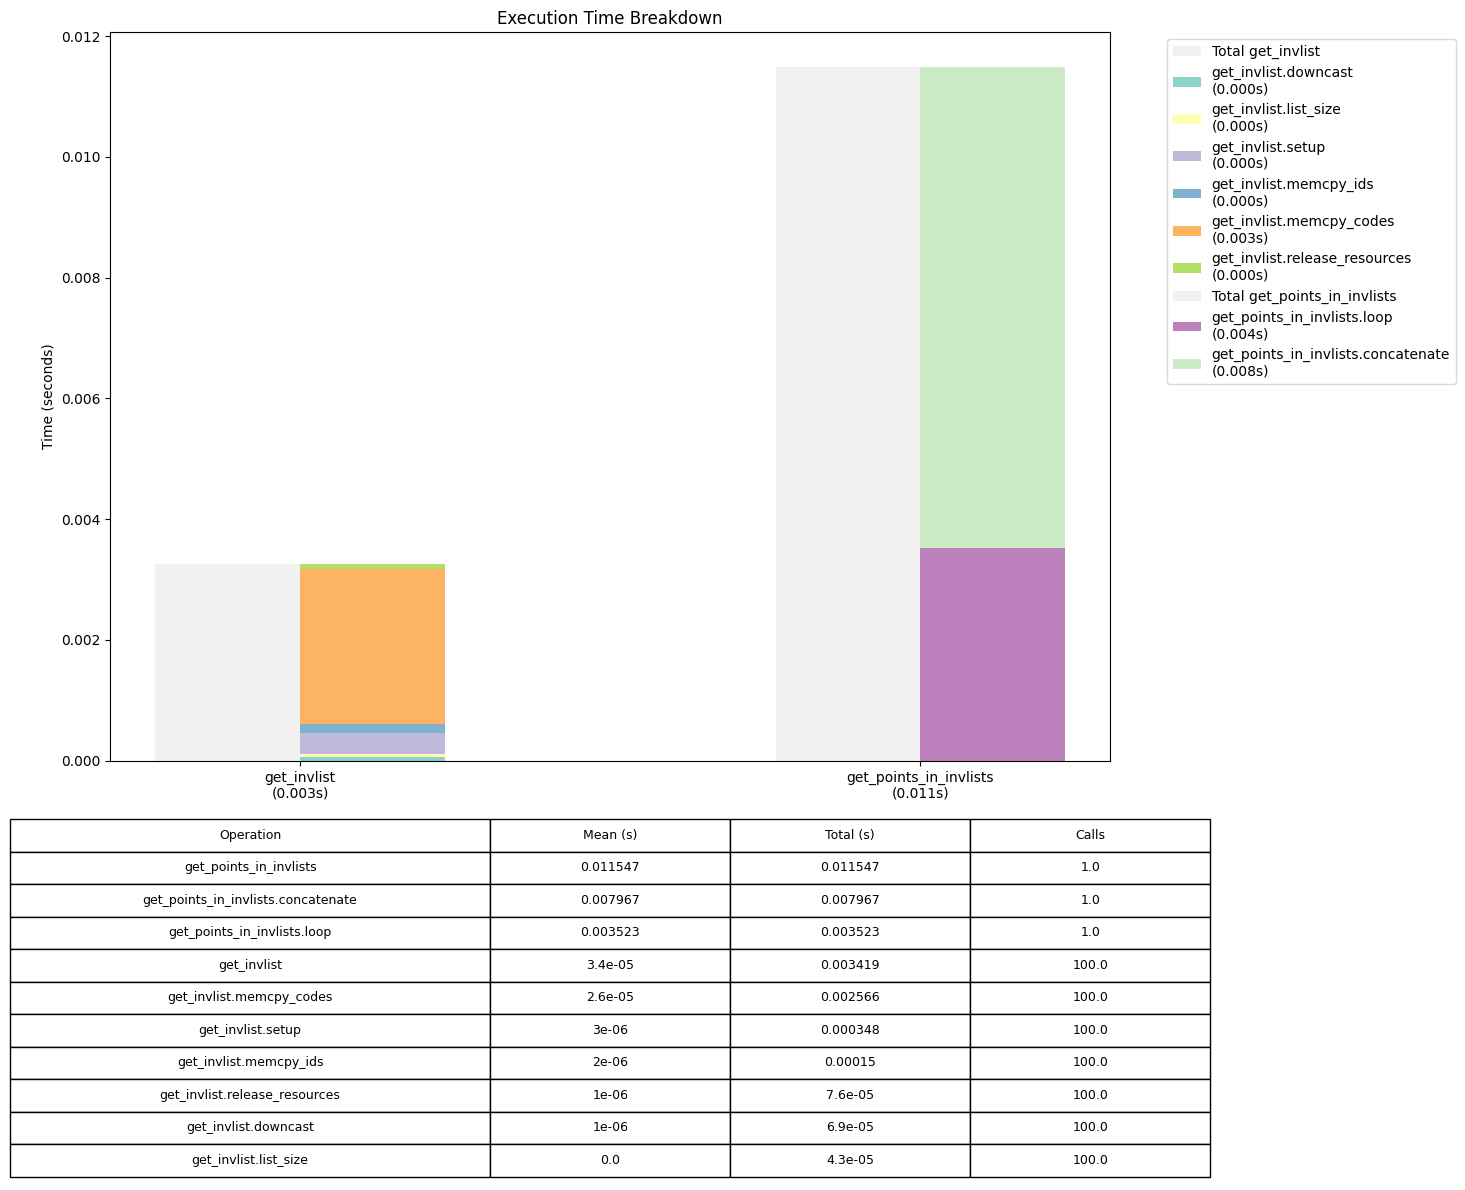

In [28]:
# For each test run, clear any existing plots first
plt.close('all')  

# Run the test
c_visited_ids = list(range(100))
pids_visited, p_visited = test_performance(c_visited_ids, index, xb=xb, DEBUG=True)

# Create and show the plot
fig = profiler.plot_timing_breakdown()  # Get the figure object
if fig:  # Only show if we got a valid figure
    plt.show()
    plt.close(fig)  # Clean up after showing

# Save timing data if needed
df = pd.DataFrame([
    {'Operation': key, 'Time (s)': value}
    for key, values in profiler.timing_data.items()
    for value in values
])
df.to_csv('timing_data_with_xb.csv', index=False)